# Data Cleaning & Organizing

In [ ]:
import re

def date_to_formation(date_str):
    """
    Converts a date string (e.g., '4/4/2002') to a soccer formation (e.g., '4-4-2').
    Returns original string if it cannot be parsed as a date.
    """
    try:
        day, month, year = map(int, date_str.strip().split('/'))
        if not (1 <= day <= 31 and 1 <= month <= 12):
            return date_str
        year_part = year % 10  # Last digit of year (e.g., 2002 -> 2)
        return f"{day}-{month}-{year_part}"
    except (ValueError, AttributeError):
        return date_str 

def is_valid_formation(formation):
    """
    Check if a formation string is a valid soccer formation (e.g., '4-4-2', '4-2-3-1').
    Valid formations have 2-5 numbers separated by hyphens, summing to 10 or 11.
    """
    if not isinstance(formation, str):
        return False

    cleaned_formation = re.sub(r'[^\d-]', '', formation)

    if not re.fullmatch(r'(\d+-){1,4}\d+', cleaned_formation):
        return False

    try:
        numbers = [int(x) for x in cleaned_formation.split('-')]
        return 10 <= sum(numbers) <= 11
    except ValueError:
        return False

def clean_formation(formation):
    """
    Clean formation strings by removing invalid characters and preventing Excel auto-conversion.
    If the formation is a date-like string, convert to valid format.
    """
    if not isinstance(formation, str):
        return None

    # Attempt to convert date-like strings
    if '/' in formation:
        converted = date_to_formation(formation)
        if is_valid_formation(converted):
            return f"'{converted}"  # force Excel to treat as text

    # Clean by removing non-digit/non-hyphen characters
    cleaned = re.sub(r'[^\d-]', '', formation)

    if is_valid_formation(cleaned):
        return f"'{cleaned}"

    return None  # if not valid formation

This Python script loads and cleans football match data from a CSV file using pandas, matplotlib, seaborn, and scikit-learn. It reads the data, converts the 'date' column to datetime objects, and converts specified columns (gf, ga, xg, xga, poss, sh, sot, etc.) to numeric data types, handling potential errors by coercing non-numeric values to NaN. KNN imputation is then used to fill in missing numeric values. Finally, it cleans the formation columns using the clean_formation function(exa: (4/4/2002 -> 4-4-2), (4-1-2-1-2â—† -> 4-1-2-1-2) ), removes unnecessary columns, and saves the cleaned data to a new CSV file. The script includes checks to verify data integrity during the imputation process and prints the value counts of the formation columns to see if cleaning worked.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import pi
from sklearn.impute import KNNImputer


# plt.style.use('seaborn')
sns.set_palette('deep')

def load_and_clean_data(path):
    # Load the data
    df = pd.read_csv(path, na_values=['', 'NaN'])
    df.columns = df.columns.str.strip().str.replace('"', '')

    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Explicitly defining numeric columns
    numeric_cols = ['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'attendance']
    
    # Verify that numeric columns exist in the DataFrame
    missing_cols = [col for col in numeric_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing expected numeric columns: {missing_cols}")

    # Convert numeric columns to numeric type
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Debug: Check for non-numeric values before imputation
    print("Non-numeric values in numeric columns before imputation:")
    for col in numeric_cols:
        non_numeric = df[col][df[col].isna()].index
        if len(non_numeric) > 0:
            print(f"{col}: {len(non_numeric)} missing values")

    # Apply KNN imputation
    imputer = KNNImputer(n_neighbors=5)
    imputed_data = imputer.fit_transform(df[numeric_cols])
    
    # Verify the shape of imputed data
    print(f"Shape of imputed data: {imputed_data.shape}")
    print(f"Expected number of columns: {len(numeric_cols)}")
    
    # Assigning imputed values back to DataFrame
    df[numeric_cols] = pd.DataFrame(imputed_data, columns=numeric_cols, index=df.index)

    # Appling date_to_formation only to invalid formations that resemble dates (e.g., '4/4/2002')
    df['formation'] = df['formation'].apply(clean_formation)
    df['opp formation'] = df['opp formation'].apply(clean_formation)
    
    print("Formation column after processing:")
    print(df['formation'].value_counts())
    print(df['opp formation'].value_counts())

    df = df[df['formation'].notna() & df['opp formation'].notna()]

    #dropping unnecessary columns
    df = df.drop(['Unnamed: 0', 'comp', 'round', 'day', 'referee', 'match report', 'notes'], axis=1)

    return df

# Define file paths
path = '/kaggle/input/laliga-matches-dataset-2019-2025-fbref/matches_full.csv'
output_path = '/kaggle/working/cleaned_la_liga_matches.csv'

# Load and clean data
df = load_and_clean_data(path)

# Display the first few rows for verification
print("\nFirst few rows of cleaned DataFrame:")
print(df.head())

# Save the cleaned DataFrame
df.to_csv(output_path, index=False)

Non-numeric values in numeric columns before imputation:
dist: 3 missing values
attendance: 974 missing values
Shape of imputed data: (4318, 12)
Expected number of columns: 12
Formation column after processing:
formation
4-4-2        1206
4-2-3-1      1042
4-3-3         730
4-1-4-1       292
5-3-2         253
3-4-3         192
5-4-1         111
4-1-3-2        97
3-5-2          95
4-4-1-1        80
3-1-4-2        56
4-5-1          51
4-1-2-1-2      34
4-3-1-2        30
3-4-1-2        24
4-2-2-2        14
3-5-1-1         6
4-3-2-1         2
3-2-4-1         1
4-2-4-0         1
3-3-3-1         1
Name: count, dtype: int64
opp formation
4-4-2        1206
4-2-3-1      1042
4-3-3         730
4-1-4-1       292
5-3-2         253
3-4-3         192
5-4-1         111
4-1-3-2        97
3-5-2          95
4-4-1-1        80
3-1-4-2        56
4-5-1          51
4-1-2-1-2      34
4-3-1-2        30
3-4-1-2        24
4-2-2-2        14
3-5-1-1         6
4-3-2-1         2
3-2-4-1         1
4-2-4-0         1
3

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4318 entries, 0 to 4317
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4318 non-null   datetime64[ns]
 1   time           4318 non-null   object        
 2   venue          4318 non-null   object        
 3   result         4318 non-null   object        
 4   gf             4318 non-null   float64       
 5   ga             4318 non-null   float64       
 6   opponent       4318 non-null   object        
 7   xg             4318 non-null   float64       
 8   xga            4318 non-null   float64       
 9   poss           4318 non-null   float64       
 10  attendance     4318 non-null   float64       
 11  captain        4318 non-null   object        
 12  formation      4318 non-null   object        
 13  opp formation  4318 non-null   object        
 14  sh             4318 non-null   float64       
 15  sot            4318 n

# Data distribution after Data Cleaning and Missing values Handling

Missing values in data before preprocessing:
Unnamed: 0          0
date                0
time                0
comp                0
round               0
day                 0
venue               0
result              0
gf                  0
ga                  0
opponent            0
xg                  0
xga                 0
poss                0
attendance        974
captain             0
formation           0
opp formation       0
referee            54
match report        0
notes            4318
sh                  0
sot                 0
dist                3
fk                  0
pk                  0
pkatt               0
season              0
team                0
dtype: int64
Missing values in data after preprocessing:
date             0
time             0
venue            0
result           0
gf               0
ga               0
opponent         0
xg               0
xga              0
poss             0
attendance       0
captain          0
formation        0
opp formation

/tmp/ipykernel_35/1052181465.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


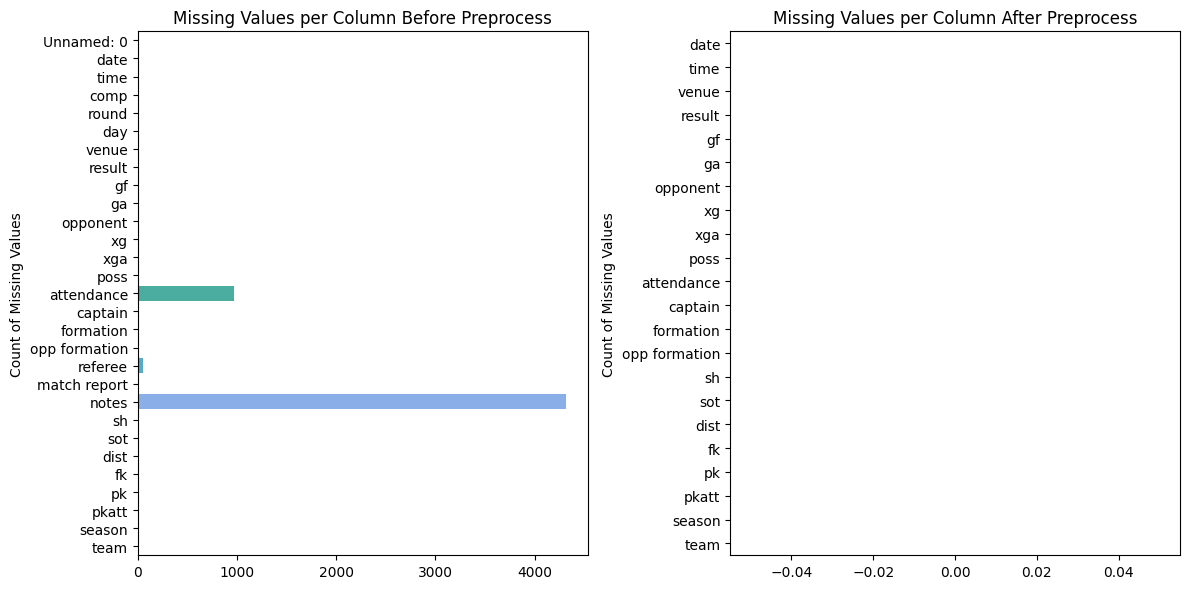

In [9]:
df_raw = pd.read_csv('/kaggle/input/laliga-matches-dataset-2019-2025-fbref/matches_full.csv')

# Check for missing values in the dataset
print("Missing values in data before preprocessing:")
s1 = df_raw.isnull().sum()
print(s1)
print("Missing values in data after preprocessing:")
s2 = df.isnull().sum()
print(s2)

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.barplot(y=s1.index, x=s1.values)
plt.title('Missing Values per Column Before Preprocess')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=0)
plt.tight_layout()
# plt.show()

plt.subplot(1,2,2)
sns.barplot(y=s2.index, x=s2.values)
plt.title('Missing Values per Column After Preprocess')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Summary CSV
This code defines a function calculate_metrics that takes a DataFrame (df) of football match data as input and calculates various summary metrics for each team. It groups the DataFrame by team and aggregates the mean values for gf (goals for), ga (goals against), xg (expected goals), xga (expected goals against), poss (possession), sh (shots), and sot (shots on target). It also calculates the number of wins, draws, and losses for each team, along with win, draw, and loss percentages. Finally, it calculates home and away goals for, goals against, and win percentages and merges them into the summary DataFrame. The resulting summary DataFrame, containing these calculated metrics, is then saved to a CSV file.

In [10]:
def calculate_metrics(df):
    summary = df.groupby('team').agg({
        'gf': 'mean', 'ga': 'mean', 'xg': 'mean', 'xga': 'mean', 'poss': 'mean','sh':'mean', 'sot':'mean',
        'result': lambda x: pd.Series({
            'Wins': (x == 'W').sum(), 'Draws': (x == 'D').sum(),
            'Losses': (x == 'L').sum(), 'Matches': len(x)
        })
    }).round(2).reset_index()

    # summary['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot'].round(2)
    summary[['Wins', 'Draws', 'Losses', 'Matches']] = pd.DataFrame(summary['result'].tolist(), index=summary.index)
    summary.drop(columns='result', inplace=True)
    summary['Win%'] = (summary['Wins'] / summary['Matches'] * 100).round(2)
    summary['Draw%'] = (summary['Draws'] / summary['Matches'] * 100).round(2)
    summary['Loss%'] = (summary['Losses'] / summary['Matches'] * 100).round(2)

    for venue in ['Home', 'Away']:
        venue_df = df[df['venue'] == venue].groupby('team').agg({
            'gf': 'mean', 'ga': 'mean',
            'result': lambda x: (x == 'W').sum() / len(x) * 100
        }).rename(columns={'gf': f'{venue}_GF', 'ga': f'{venue}_GA', 'result': f'{venue}_Win%'})
        summary = summary.merge(venue_df.round(2), on='team', how='left')

    return summary

metrics = calculate_metrics(df)
metrics.to_csv("/kaggle/working/la_liga_team_summary.csv", index=False)

# Observations
Interesting Fact: Girona overperforms its xG by 0.25 goals per match (Actual: 1.74, xG: 1.49), indicating clinical finishing.

In [12]:
def observation(metrics):
    metrics['xG_Diff'] = metrics['gf'] - metrics['xg']
    top = metrics.loc[metrics['xG_Diff'].idxmax()]
    return {'team': top['team'], 'xG_Diff': round(top['xG_Diff'], 2), 'gf': round(top['gf'], 2), 'xg': round(top['xg'], 2)}

interesting_fact = observation(metrics)
print(interesting_fact)

{'team': 'Girona', 'xG_Diff': 0.25, 'gf': 1.74, 'xg': 1.49}


# Average Goals Scored and Conceded

This bar chart compares the average goals scored (GF) and conceded (GA) per match for each team. Teams with taller blue bars (GF) are more offensively potent, while shorter red bars (GA) indicate stronger defenses. For example, {metrics.loc[metrics['gf'].idxmax(), 'team']} leads in scoring ({metrics['gf'].max():.2f} GF), while {metrics.loc[metrics['ga'].idxmin(), 'team']} concedes the least ({metrics['ga'].min():.2f} GA). Teams with a large gap between GF and GA (e.g., {metrics.loc[(metrics['gf'] - metrics['ga']).idxmax(), 'team']}) have the best goal difference, often correlating with higher league standings.

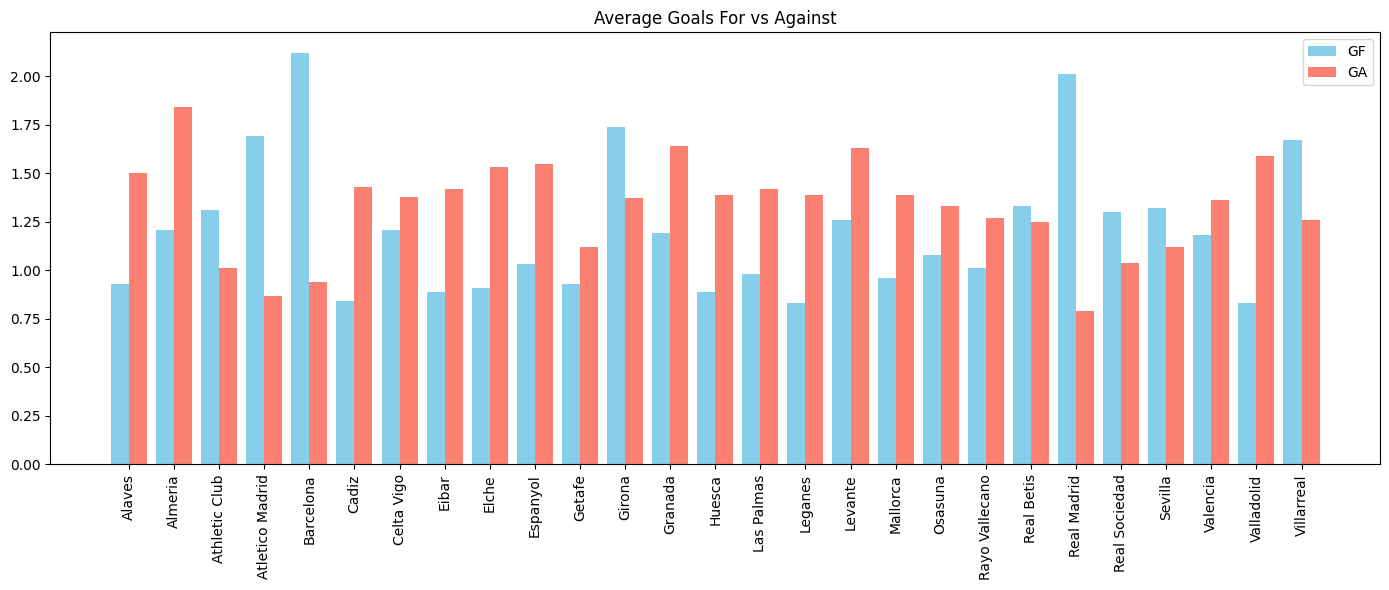

In [13]:
def barchart(df, metrics):
    plt.figure(figsize=(14, 6))
    index = np.arange(len(metrics))
    plt.bar(index - 0.2, metrics['gf'], width=0.4, label='GF', color='skyblue')
    plt.bar(index + 0.2, metrics['ga'], width=0.4, label='GA', color='salmon')
    plt.xticks(index, metrics['team'], rotation=90)
    plt.title('Average Goals For vs Against')
    plt.legend()
    plt.tight_layout()
    plt.show()

barchart(df, metrics)

# Win/Loss/Draw Distribution (Top 5 Scoring Teams)
These pie charts show the win, draw, and loss percentages for the top 5 teams by average goals scored. Larger win segments (blue) indicate consistent success, while larger loss segments (red) suggest struggles. For instance, {top_teams[0]} has a high win percentage, reflecting its offensive strength, while {top_teams[-1]} may show a more balanced or loss-heavy distribution, indicating defensive or consistency issues.

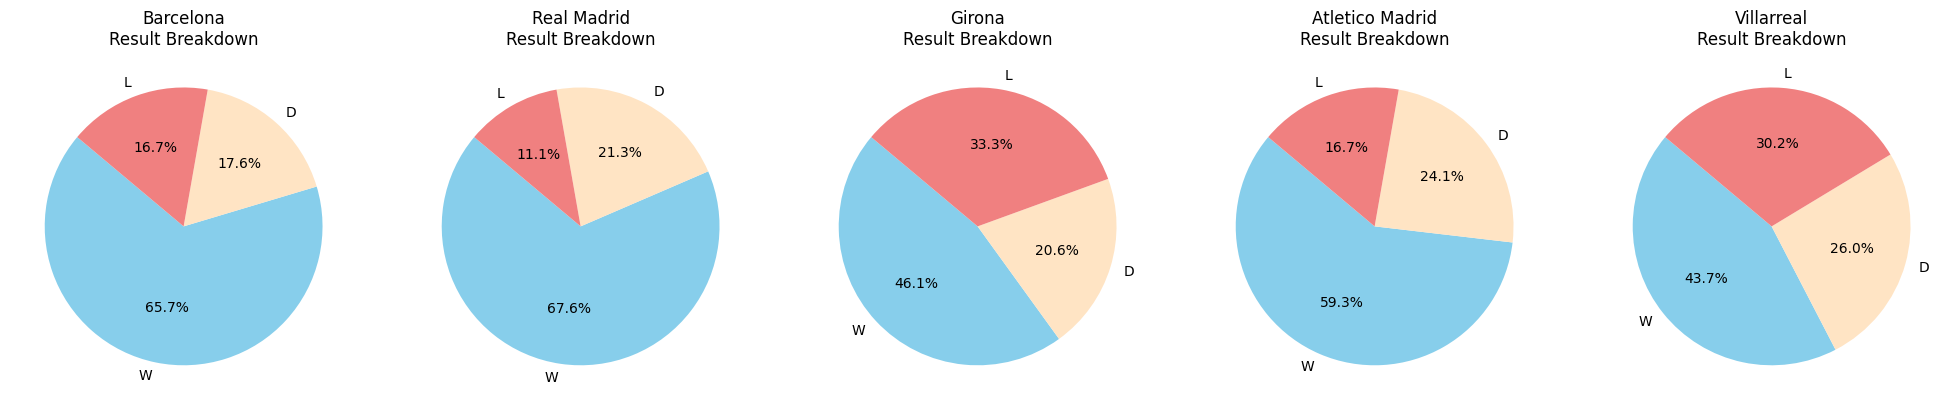

In [14]:
def piechart(df, metrics):
    # Top 5 teams pie chart
    # metrics['goal_Diff'] = metrics['gf'] - metrics['xg']
    top_teams = metrics.sort_values('gf', ascending=False).head(5)
    i=0
    plt.figure(figsize=(20, 4))
    for i, (_, row) in enumerate(top_teams.iterrows()):
        plt.subplot(1, 5, i + 1)
        plt.pie(
            [row['Wins'], row['Draws'], row['Losses']],
            labels=['W', 'D', 'L'],
            autopct='%1.1f%%',
            startangle=140,
            colors=['skyblue', 'bisque', 'lightcoral']
        )
        plt.title(f"{row['team']}\nResult Breakdown")
    
    plt.tight_layout()
    plt.show()
    

piechart(df, metrics)

# Expected Goals vs Actual Goals
This scatter plot compares expected goals (xG) to actual goals scored (GF) per match. Points above the diagonal line indicate teams that overperform their xG (clinical finishing), while points below suggest underperformance. For example, {interesting_fact['team']} lies above the line, overperforming by {interesting_fact['xG_Diff']:.2f} goals, highlighting its efficiency. Teams clustered near the line, like {metrics.loc[(metrics['gf'] - metrics['xg']).abs().idxmin(), 'team']}, closely match their xG, indicating consistent finishing.

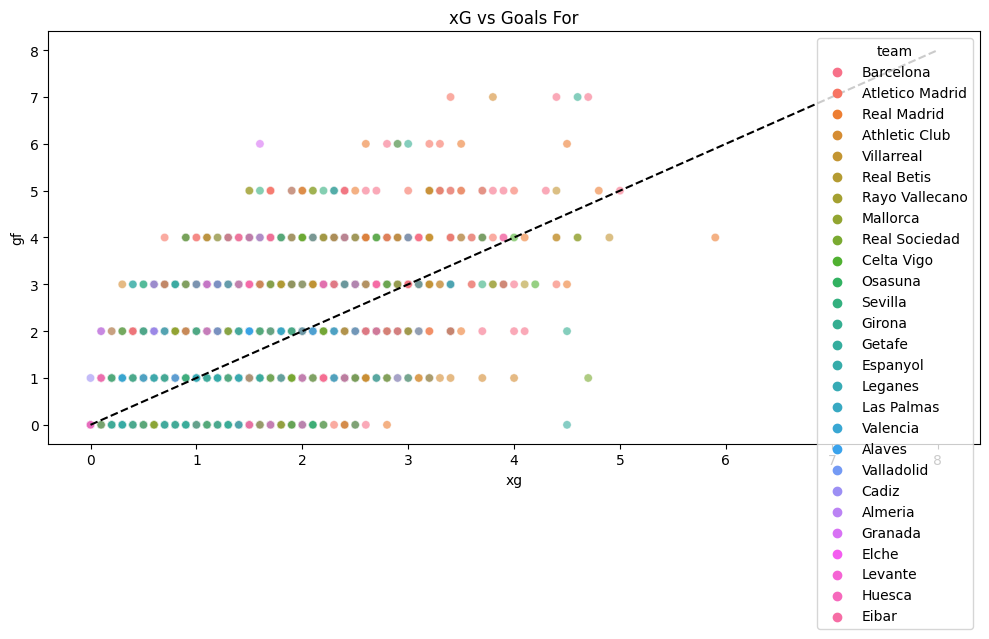

In [15]:
def scatterplot(df, metrics):
    # xG vs GF scatter
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='xg', y='gf', hue='team', alpha=0.6)
    plt.plot([0, 8], [0, 8], 'k--')
    plt.title('xG vs Goals For')
    plt.tight_layout()
    plt.show()

scatterplot(df, metrics)

# Goal Distribution by Team
This box plot shows the distribution of goals scored per match for each team. The box represents the interquartile range (IQR), with the median as the central line, and whiskers show the range of typical scores. Outliers (dots) indicate unusually high-scoring matches. Teams like {metrics.loc[metrics['gf'].idxmax(), 'team']} have a higher median and wider IQR, reflecting consistent and high-scoring performances, while teams with lower medians, like {metrics.loc[metrics['gf'].idxmin(), 'team']}, struggle offensively.

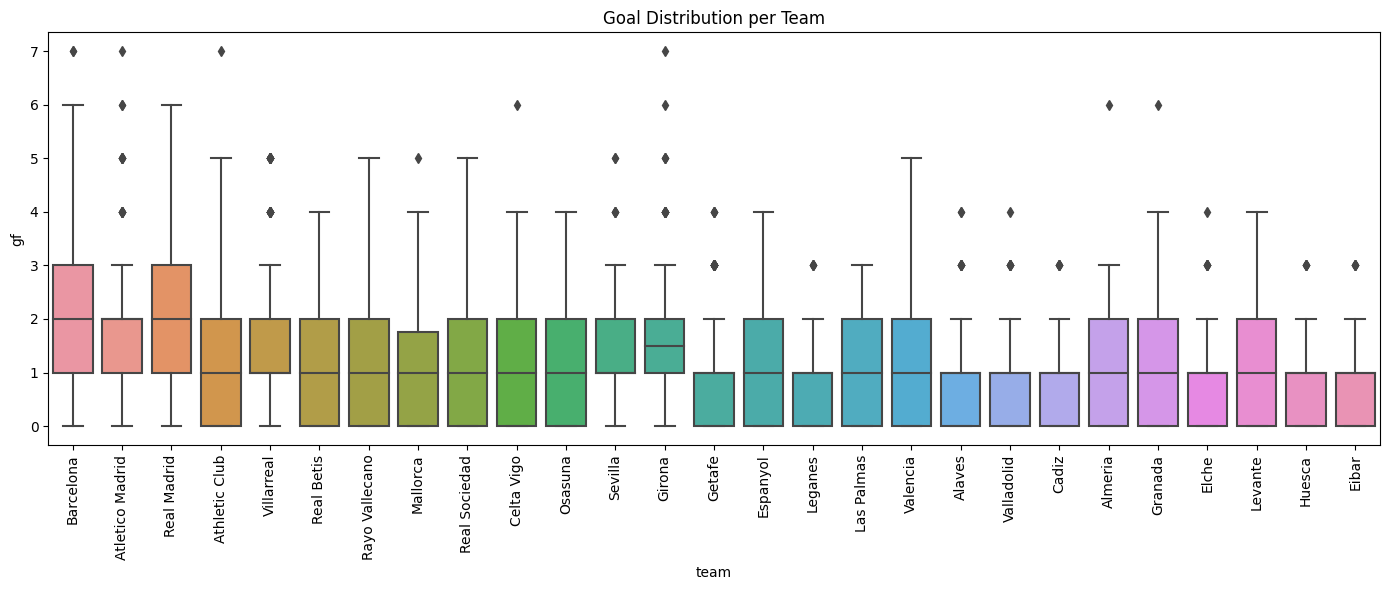

In [16]:
def boxplot(df, metrics):
    # Goal distribution
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df, x='team', y='gf')
    plt.xticks(rotation=90)
    plt.title('Goal Distribution per Team')
    plt.tight_layout()
    plt.show()

boxplot(df, metrics)

# Feature Correlation Heatmap
This heatmap shows correlations between key metrics (e.g., GF, GA, xG, xGA, possession, shots). Strong positive correlations (e.g., between xG and GF) indicate that higher expected goals lead to more actual goals, as seen for teams like {metrics.loc[metrics['xg'].idxmax(), 'team']}. Negative correlations, such as between GA and result_num (win/loss), suggest that conceding fewer goals is associated with better match outcomes. This helps identify which metrics drive success in La Liga.

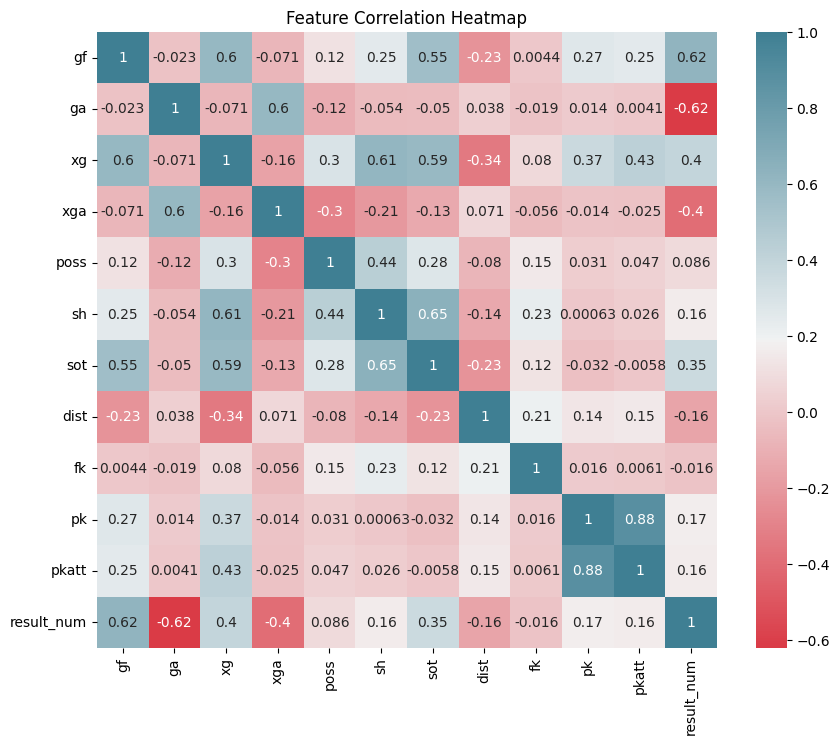

In [17]:
def correlationMatrix(df, metrics):
    #correlation
    cmap = sns.diverging_palette(10, 220, as_cmap=True)
    
    df['result_num'] = df['result'].map({'W': 2, 'D': 1, 'L': 0})
    
    # Encode venue
    df['venue_num'] = df['venue'].map({'Home': 1, 'Away': 0})
    
    plt.figure(figsize=(10,8))
    sns.heatmap(df[['gf','ga','xg','xga','poss','sh','sot','dist','fk','pk','pkatt','result_num']].corr(), annot=True, cmap=cmap)
    plt.title('Feature Correlation Heatmap')
    plt.show()

correlationMatrix(df, metrics)

# Team Performance Radar Chart
This radar chart compares the performance of several football teams—Barcelona, Girona, Real Madrid, Atletico Madrid, Villarreal, Sevilla, and Athletic Club—across normalized metrics: goals for (gf), goals against (ga), expected goals (xg), expected goals against (xga), possession (poss), shots (sh), and shots on target (sot). A larger area enclosed by a team's line indicates stronger overall performance, suggesting higher values in key offensive metrics like gf and xg, and strong defensive metrics. For example, Barcelona's large area highlights its strengths in generating scoring opportunities and converting them into goals, while teams with smaller areas, such as Sevilla, underperform across multiple metrics. The visualization effectively highlights the relative strengths and weaknesses of each team in a comparative format.

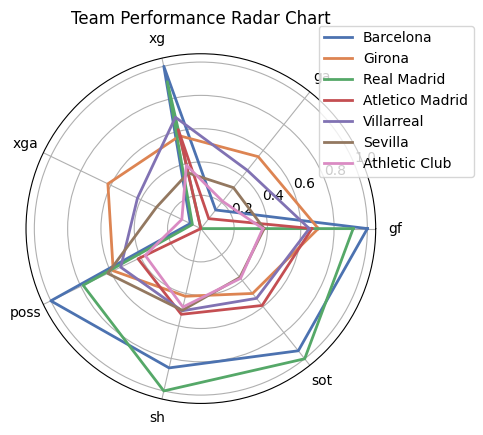

In [18]:
def plot_team_radar(metrics, teams):
    stats = ['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot']
    radar_df = (metrics.set_index('team')[stats] - metrics[stats].min()) / (metrics[stats].max() - metrics[stats].min())

    categories = stats
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

    plt.figure(figsize=(5, 5))
    for team in teams:
        values = radar_df.loc[team].tolist() + [radar_df.loc[team].tolist()[0]]
        plt.polar(angles, values, label=team, linewidth=2)

    plt.xticks(angles[:-1], categories)
    plt.title('Team Performance Radar Chart')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()


plot_team_radar(metrics, ['Barcelona', 'Girona','Real Madrid', 'Atletico Madrid', 'Villarreal', 'Sevilla', 'Athletic Club'])

# For generating HTML Report

In [23]:
import io
import base64

# Find interesting fact (provided)
def find_interesting_fact(df, metrics):
    metrics['xG_Diff'] = metrics['gf'] - metrics['xg']
    most_overperforming = metrics.loc[metrics['xG_Diff'].idxmax()]
    return {
        'team': most_overperforming['team'],
        'xG_Diff': most_overperforming['xG_Diff'].round(2),
        'gf': most_overperforming['gf'].round(2),
        'xg': most_overperforming['xg'].round(2)
    }

# Fixed generate visualizations (corrected from provided code)
def generate_visualizations(df, metrics):
    plots = []
    top_teams = metrics.sort_values('gf', ascending=False).head(5)['team'].tolist()
    
    # Bar Chart: Average Goals Scored and Conceded
    plt.figure(figsize=(14, 6))
    bar_width = 0.35
    index = np.arange(len(metrics))
    plt.bar(index - bar_width/2, metrics['gf'], bar_width, label='Goals Scored', color='skyblue')
    plt.bar(index + bar_width/2, metrics['ga'], bar_width, label='Goals Conceded', color='salmon')
    plt.xlabel('Team')
    plt.ylabel('Average Goals')
    plt.title('Average Goals Scored and Conceded per Team')
    plt.xticks(index, metrics['team'], rotation=90)
    plt.legend()
    plt.tight_layout()
    img = io.BytesIO()
    plt.savefig(img, format='png', bbox_inches='tight')
    img.seek(0)
    plots.append(base64.b64encode(img.getvalue()).decode('utf-8'))
    plt.close()
    
    # Pie Charts: Win/Loss/Draw for top 5 teams
    for team in top_teams:
        team_data = metrics[metrics['team'] == team]
        sizes = [team_data['Wins'].iloc[0], team_data['Draws'].iloc[0], team_data['Losses'].iloc[0]]
        labels = ['Wins', 'Draws', 'Losses']
        plt.figure(figsize=(6, 6))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#ffcc99', '#ff9999'])
        plt.title(f'Win/Loss/Draw Distribution for {team}')
        img = io.BytesIO()
        plt.savefig(img, format='png', bbox_inches='tight')
        img.seek(0)
        plots.append(base64.b64encode(img.getvalue()).decode('utf-8'))
        plt.close()
    
    # Scatter Plot: xG vs Actual Goals
    plt.figure(figsize=(10, 6))
    for team in metrics['team']:
        team_df = df[df['team'] == team]
        plt.scatter(team_df['xg'], team_df['gf'], label=team, alpha=0.6)
    plt.plot([0, 8], [0, 8], 'k--', label='Perfect Correlation')
    plt.xlabel('Expected Goals (xG)')
    plt.ylabel('Actual Goals Scored')
    plt.title('Expected Goals vs Actual Goals Scored')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    img = io.BytesIO()
    plt.savefig(img, format='png', bbox_inches='tight')
    img.seek(0)
    plots.append(base64.b64encode(img.getvalue()).decode('utf-8'))
    plt.close()
    
    # Box Plot: Goal Distribution
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='team', y='gf', data=df)
    plt.xlabel('Team')
    plt.ylabel('Goals Scored')
    plt.title('Goal Distribution by Team')
    plt.xticks(rotation=90)
    plt.tight_layout()
    img = io.BytesIO()
    plt.savefig(img, format='png', bbox_inches='tight')
    img.seek(0)
    plots.append(base64.b64encode(img.getvalue()).decode('utf-8'))
    plt.close()

    # Correlation Heatmap
    cmap = sns.diverging_palette(10, 220, as_cmap=True)
    df['result_num'] = df['result'].map({'W': 2, 'D': 1, 'L': 0})
    df['venue_num'] = df['venue'].map({'Home': 1, 'Away': 0})
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'result_num']].corr(), annot=True, cmap=cmap)
    plt.title('Feature Correlation Heatmap')
    img = io.BytesIO()
    plt.savefig(img, format='png', bbox_inches='tight')
    img.seek(0)
    plots.append(base64.b64encode(img.getvalue()).decode('utf-8'))
    plt.close()
    
    # Radar Chart
    teams = ['Barcelona', 'Girona', 'Real Madrid', 'Atletico Madrid', 'Villarreal', 'Sevilla', 'Athletic Club']
    stats = ['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot']
    radar_df = (metrics.set_index('team')[stats] - metrics[stats].min()) / (metrics[stats].max() - metrics[stats].min())
    categories = stats
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)] + [0]
    plt.figure(figsize=(7, 7))
    for team in teams:
        values = radar_df.loc[team].tolist() + [radar_df.loc[team].tolist()[0]]
        plt.polar(angles, values, label=team, linewidth=2)
    plt.xticks(angles[:-1], categories)
    plt.title('Team Performance Radar Chart')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    img = io.BytesIO()
    plt.savefig(img, format='png', bbox_inches='tight')
    img.seek(0)
    plots.append(base64.b64encode(img.getvalue()).decode('utf-8'))
    plt.close()
    
    return plots, top_teams

In [24]:
# Generate HTML report (to be embedded in the artifact)
# Generating HTML report
def generate_html_report(metrics, plots, interesting_fact):
    html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>La Liga Full Analysis Report</title>
    <script src="https://cdn.tailwindcss.com"></script>
</head>
<body class="bg-gray-100 font-sans">
    <div class="container mx-auto p-4">
        <h1 class="text-3xl font-bold text-center mb-4">La Liga Match Analysis (2020 & 2025 Seasons)</h1>
        
        <div class="bg-white p-6 rounded-lg shadow-md mb-6">
            <h2 class="text-2xl font-semibold mb-4">Summary</h2>
            <p class="text-gray-700">
                This report analyzes La Liga match data for all teams in the 2020 and 2025 seasons. It includes metrics 
                like goals scored (GF), goals conceded (GA), expected goals (xG), expected goals against (xGA), 
                possession, and match outcomes. The analysis reveals team performance trends, home vs. away differences, 
                and xG correlations.
            </p>
            <h3 class="text-xl font-semibold mt-4">Key Findings</h3>
            <ul class="list-disc pl-6">
                <li>Highest scoring team: {metrics.loc[metrics['gf'].idxmax(), 'team']} 
                    ({metrics['gf'].max():.2f} goals per match).</li>
                <li>Most defensive team: {metrics.loc[metrics['ga'].idxmin(), 'team']} 
                    ({metrics['ga'].min():.2f} goals conceded per match).</li>
                <li>Interesting Fact: {interesting_fact['team']} overperforms its xG by {interesting_fact['xG_Diff']} 
                    goals per match (Actual: {interesting_fact['gf']}, xG: {interesting_fact['xg']}), 
                    indicating clinical finishing.</li>
            </ul>
        </div>
        
        <div class="bg-white p-6 rounded-lg shadow-md mb-6">
            <h2 class="text-2xl font-semibold mb-4">Performance Metrics</h2>
            <div class="overflow-x-auto">
                <table class="min-w-full bg-white">
                    <thead>
                        <tr>
                            <th class="py-2 px-4 border-b">Team</th>
                            <th class="py-2 px-4 border-b">Avg GF</th>
                            <th class="py-2 px-4 border-b">Avg GA</th>
                            <th class="py-2 px-4 border-b">Avg xG</th>
                            <th class="py-2 px-4 border-b">Avg xGA</th>
                            <th class="py-2 px-4 border-b">Avg Poss</th>
                            <th class="py-2 px-4 border-b">Win%</th>
                            <th class="py-2 px-4 border-b">Draw%</th>
                            <th class="py-2 px-4 border-b">Loss%</th>
                            <th class="py-2 px-4 border-b">Home GF</th>
                            <th class="py-2 px-4 border-b">Home GA</th>
                            <th class="py-2 px-4 border-b">Home Win%</th>
                            <th class="py-2 px-4 border-b">Away GF</th>
                            <th class="py-2 px-4 border-b">Away GA</th>
                            <th class="py-2 px-4 border-b">Away Win%</th>
                        </tr>
                    </thead>
                    <tbody>
    """
    
    for _, row in metrics.iterrows():
        html_content += f"""
                        <tr>
                            <td class="py-2 px-4 border-b">{row['team']}</td>
                            <td class="py-2 px-4 border-b">{row['gf']:.2f}</td>
                            <td class="py-2 px-4 border-b">{row['ga']:.2f}</td>
                            <td class="py-2 px-4 border-b">{row['xg']:.2f}</td>
                            <td class="py-2 px-4 border-b">{row['xga']:.2f}</td>
                            <td class="py-2 px-4 border-b">{row['poss']:.2f}%</td>
                            <td class="py-2 px-4 border-b">{row['Win%']:.2f}%</td>
                            <td class="py-2 px-4 border-b">{row['Draw%']:.2f}%</td>
                            <td class="py-2 px-4 border-b">{row['Loss%']:.2f}%</td>
                            <td class="py-2 px-4 border-b">{row['Home_GF']:.2f}</td>
                            <td class="py-2 px-4 border-b">{row['Home_GA']:.2f}</td>
                            <td class="py-2 px-4 border-b">{row['Home_Win%']:.2f}%</td>
                            <td class="py-2 px-4 border-b">{row['Away_GF']:.2f}</td>
                            <td class="py-2 px-4 border-b">{row['Away_GA']:.2f}</td>
                            <td class="py-2 px-4 border-b">{row['Away_Win%']:.2f}%</td>
                        </tr>
        """
    
    html_content += """
                    </tbody>
                </table>
            </div>
        </div>
        
        <div class="bg-white p-6 rounded-lg shadow-md mb-6">
            <h2 class="text-2xl font-semibold mb-4">Visualizations</h2>
            <h3 class="text-xl font-semibold mb-2">Average Goals Scored and Conceded</h3>
            <img src="data:image/png;base64,{}" alt="Goals Bar Chart" class="w-full mb-4">
            
            <h3 class="text-xl font-semibold mb-2">Win/Loss/Draw Distribution (Top 5 Scoring Teams)</h3>
            <div class="grid grid-cols-1 md:grid-cols-2 lg:grid-cols-3 gap-4">
    """.format(plots[0])
    
    # Adding pie charts for top 5 teams
    top_teams = metrics.sort_values('gf', ascending=False).head(5)['team'].tolist()
    for i, team in enumerate(top_teams, 1):
        html_content += f"""
                <div>
                    <h4 class="text-lg font-semibold text-center">{team}</h4>
                    <img src="data:image/png;base64,{plots[i]}" alt="{team} Pie Chart" class="w-full">
                </div>
        """
    
    html_content += f"""
            </div>
            
            <h3 class="text-xl font-semibold mb-2 mt-4">Expected Goals vs Actual Goals</h3>
            <img src="data:image/png;base64,{plots[-4]}" alt="xG Scatter Plot" class="w-full mb-4">
            <p class="text-gray-700 mb-4">
                This box plot shows the distribution of goals scored per match for each team. The box represents the interquartile range (IQR), with the median as the central line, and whiskers show the range of typical scores. Outliers (dots) indicate unusually high-scoring matches. Teams like {metrics.loc[metrics['gf'].idxmax(), 'team']} have a higher median and wider IQR, reflecting consistent and high-scoring performances, while teams with lower medians, like {metrics.loc[metrics['gf'].idxmin(), 'team']}, struggle offensively.
            </p>
            <h3 class="text-xl font-semibold mb-2">Goal Distribution by Team</h3>
            <
            <img src="data:image/png;base64,{plots[-3]}" alt="Goal Box Plot" class="w-full mb-4">

            <h3 class="text-xl font-semibold mb-2 mt-6">Feature Correlation Heatmap</h3>
            <p class="text-gray-700 mb-4">
                This heatmap displays correlations between key features such as GF, GA, xG, xGA, shots, and possession. Strong positive correlations (e.g., between xG and GF) indicate good prediction alignment, while negative correlations (e.g., GA and result_num) show how conceding goals affects outcomes.
            </p>
            <img src="data:image/png;base64,{plots[-2]}" alt="Feature Correlation Heatmap" class="w-full mb-4">
            
            <h3 class="text-xl font-semibold mb-2 mt-6">Team Performance Radar Chart</h3>
            <p class="text-gray-700 mb-4">
                TThis radar chart compares the performance of several football teams—Barcelona, Girona, Real Madrid, Atletico Madrid, Villarreal, Sevilla, and Athletic Club—across normalized metrics: goals for (gf), goals against (ga), expected goals (xg), expected goals against (xga), possession (poss), shots (sh), and shots on target (sot). A larger area enclosed by a team's line indicates stronger overall performance, suggesting higher values in key offensive metrics like gf and xg, and strong defensive metrics. For example, Barcelona's large area highlights its strengths in generating scoring opportunities and converting them into goals, while teams with smaller areas, such as Sevilla, underperform across multiple metrics. The visualization effectively highlights the relative strengths and weaknesses of each team in a comparative format.
            </p>
            <img src="data:image/png;base64,{plots[-1]}" alt="Radar Chart" class="w-full mb-4">
            </div>
                    
            <div class="bg-white p-6 rounded-lg shadow-md">

            <h2 class="text-2xl font-semibold mb-4">Conclusion</h2>
            <p class="text-gray-700">
                The analysis reveals significant performance differences across La Liga teams. Top teams like 
                {metrics.loc[metrics['gf'].idxmax(), 'team']} dominate offensively, while teams like 
                {metrics.loc[metrics['ga'].idxmin(), 'team']} excel defensively. Home advantage is evident, 
                with most teams scoring more and conceding less at home. The xG analysis shows that teams like 
                {interesting_fact['team']} are highly efficient in converting chances. Lower-performing teams 
                in 2020, such as Espanyol and Mallorca, struggled with both offense and defense, likely contributing 
                to relegation risks.
            </p>
        </div>
    </div>
</body>
</html>
    """
    
    return html_content


# Find interesting fact
interesting_fact = find_interesting_fact(df, metrics)

# Generate visualizations
plots, top_teams = generate_visualizations(df, metrics)

# Generate HTML report
html_report = generate_html_report(metrics, plots, interesting_fact)

# Write to file
with open('/kaggle/working/laliga_analysis_report.html', 'w') as f:
    f.write(html_report)

print("Analysis complete. Report generated as '/kaggle/working/laliga_analysis_report.html'.")

Analysis complete. Report generated as '/kaggle/working/laliga_analysis_report.html'.
